# Pooled OLS model for housing prices

$$
log(SP)_i \sim Normal(\mu_i, \sigma) \\
\mu_i = \alpha + \beta * log(LA)_i \\
\alpha_j\sim Normal(1, 0.5),
\beta\sim Normal(0, 0.5) \\
\sigma\sim exp(1)
$$

In [1]:
import sys
print(sys.version)

3.6.12 |Anaconda custom (x86_64)| (default, Sep  8 2020, 17:50:39) 
[GCC Clang 10.0.0 ]


In [2]:
import math
import pystan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az

az.style.use('arviz-darkgrid')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Train/Test data
train = pd.read_csv('../../data/raw/train.csv').assign(data_type = 'train')
test = pd.read_csv('../../data/raw/test.csv').assign(data_type = 'test')

# Want to ensure the encodings of the neighbourhoods as indexes are consistent
df_full = train.append(test, ignore_index = True)
df_full['neighbourhood'] = df_full['Neighborhood'].astype('category').cat.codes+1

# Log variables
df_full['log_sales_price'] = np.log(df_full['SalePrice'])
df_full['log_lot_area'] = np.log(df_full['LotArea'])

# Train/test split
train = df_full.loc[df_full['data_type'] == 'train'].copy()
test = df_full.loc[df_full['data_type'] == 'test'].copy()

# Center and scale predictor (train)
train['log_lot_area_z'] = (train[['log_lot_area']] - train[['log_lot_area']].mean()) / train[['log_lot_area']].std()

# Scale target (train)
train['log_sales_price_std'] = train['log_sales_price']/train['log_sales_price'].mean()

# Center and scale predictor using training data mean and std
test['log_lot_area_z'] = (test[['log_lot_area']] - train[['log_lot_area']].mean()) / train[['log_lot_area']].std()

# Scale target using training data mean
test['log_sales_price_std'] = test['log_sales_price']/train['log_sales_price'].mean()

## Load and simulate fake data

In [3]:
pooling_model = pystan.StanModel(file = '../../models/linear_model.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f624cc3d8d808ccfc509d79cb9030af5 NOW.


In [ ]:
pm_data_check = dict(N = len(train),
              log_sales_price = train['log_sales_price_std'],
              log_lot_area = train['log_lot_area_z'],
              N_test = len(test),
              log_lot_area_test = test['log_lot_area_z'],
              alpha_sd = 0.01, 
              beta_sd = 0.1, 
              run_estimation = 0)

fit_pm_check = pooling_model.sampling(data=pm_data_check, control=dict(adapt_delta=0.99))
pm_df_check = fit_pm_check.to_dataframe()

## Prior predictive checks

array([<matplotlib.axes._subplots.AxesSubplot object at 0x163ea0e10>],
      dtype=object)

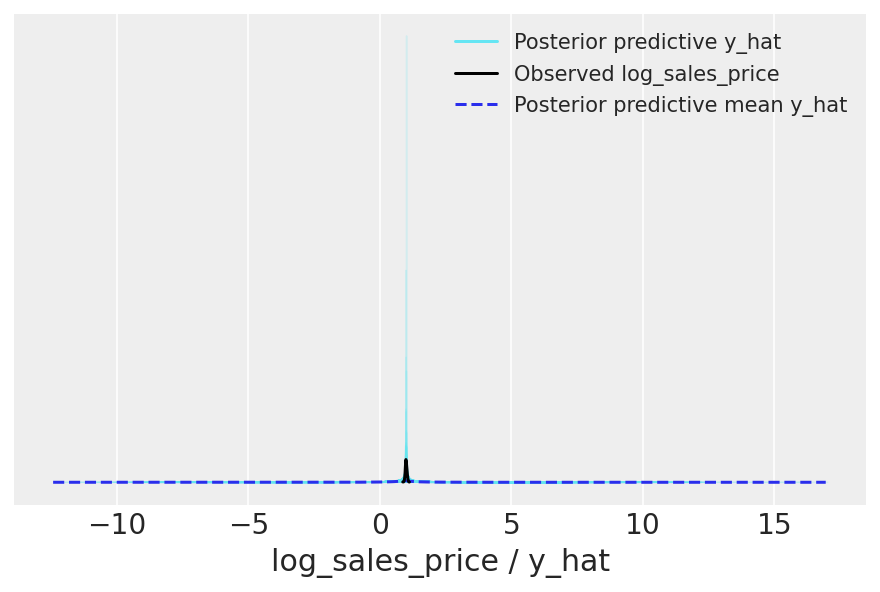

In [29]:
pm_check_az = az.from_pystan(
    posterior=fit_pm_check,
    posterior_predictive="y_hat",
    observed_data="log_sales_price",
    log_likelihood='log_lik',
)

az.plot_ppc(data = pm_check_az, kind = 'density', data_pairs = {'log_sales_price' : 'y_hat'})

#az.plot_trace(fit_model_check, var_names=["alpha_j", "beta", "sigma"], compact = True);

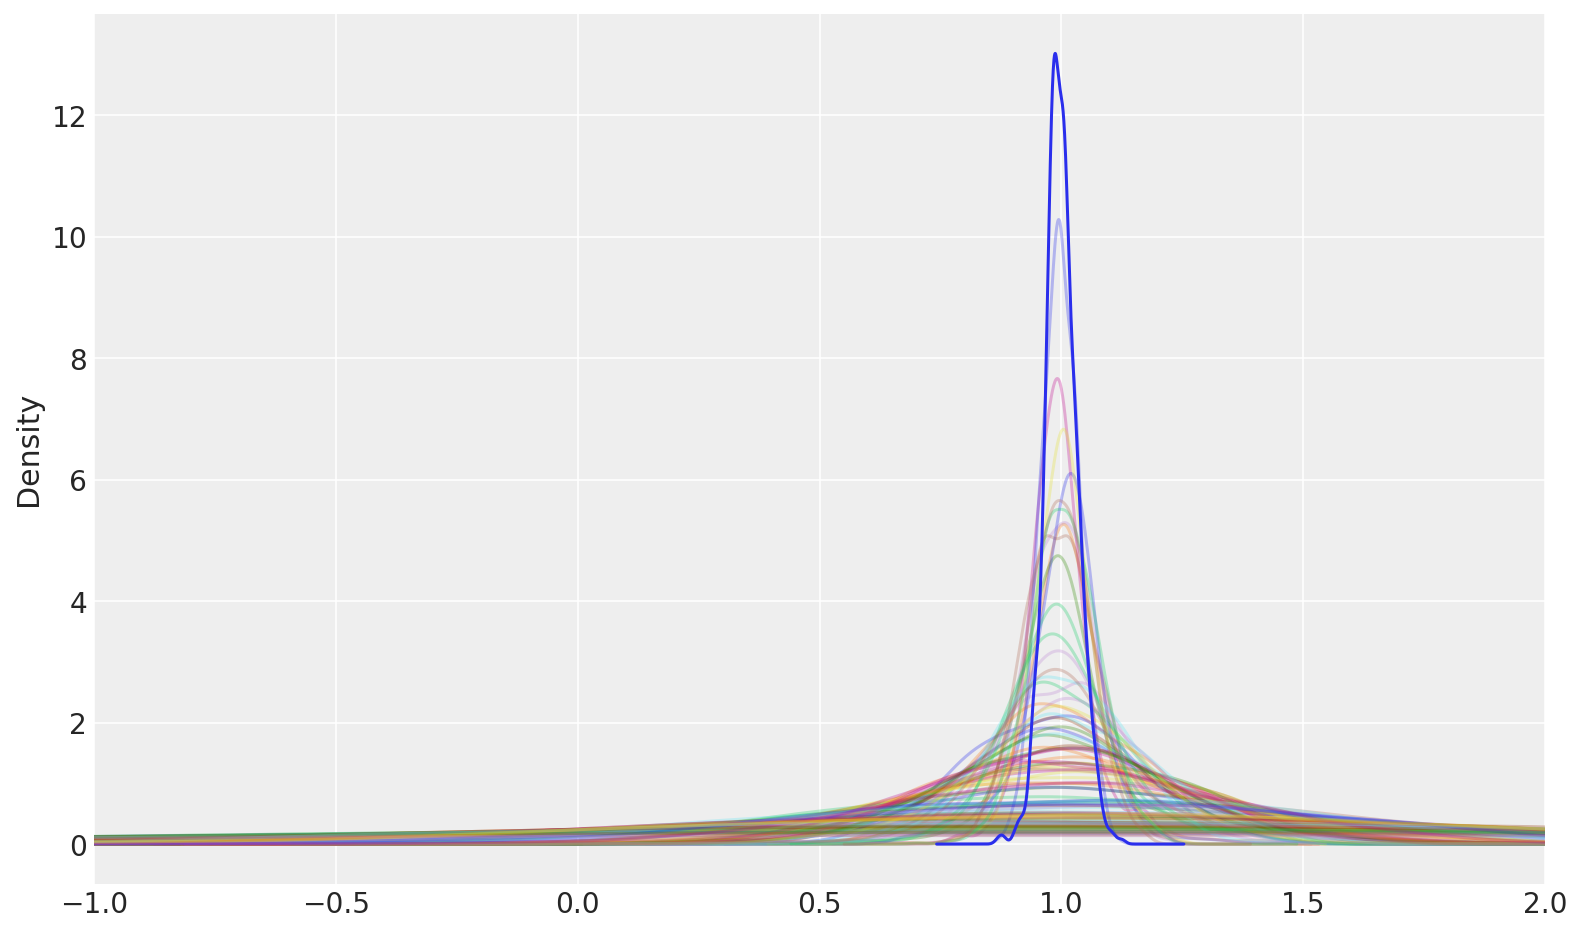

In [31]:
fig, axes = plt.subplots(1,1, figsize = (13, 8))

pm_df_check.filter(regex = 'y_hat').T.iloc[:, :100].plot.kde(alpha=0.3,
                                                        legend = False, 
                                                        xlim = (-1, 2),
                                                        ax = axes);

train['log_sales_price_std'].plot.kde(legend = False, 
                             alpha = 1,
                             ax = axes);

In [9]:
#az.plot_trace(fit_npm_check, var_names=["alpha", "beta", "sigma"], compact = True);

## Fit model on fake data and recapture known parameters (appendix?)

In [4]:
random_draw = 10
y_sim = pm_df_check.filter(regex = 'y_hat').iloc[random_draw, :]
true_parameters = pm_df_check.filter(regex = 'alpha|beta|sigma').iloc[random_draw, :]

_pm_data_check = dict(N = len(train),
              log_sales_price = y_sim,
              log_lot_area = train['log_lot_area_z'],
              N_test = len(test),
              log_lot_area_test = test['log_lot_area_z'],
              alpha_sd = 0.01, 
              beta_sd = 0.1, 
              run_estimation = 1)

_fit_pm_check = pooling_model.sampling(data=_pm_data_check, control=dict(adapt_delta=0.99))
_pm_df_check = fit_pm_check.to_dataframe()
fake_fit = _pm_df_check.filter(regex = 'alpha|beta|sigma')
parameter_df = pd.melt(fake_fit)

NameError: name 'pm_df_check' is not defined

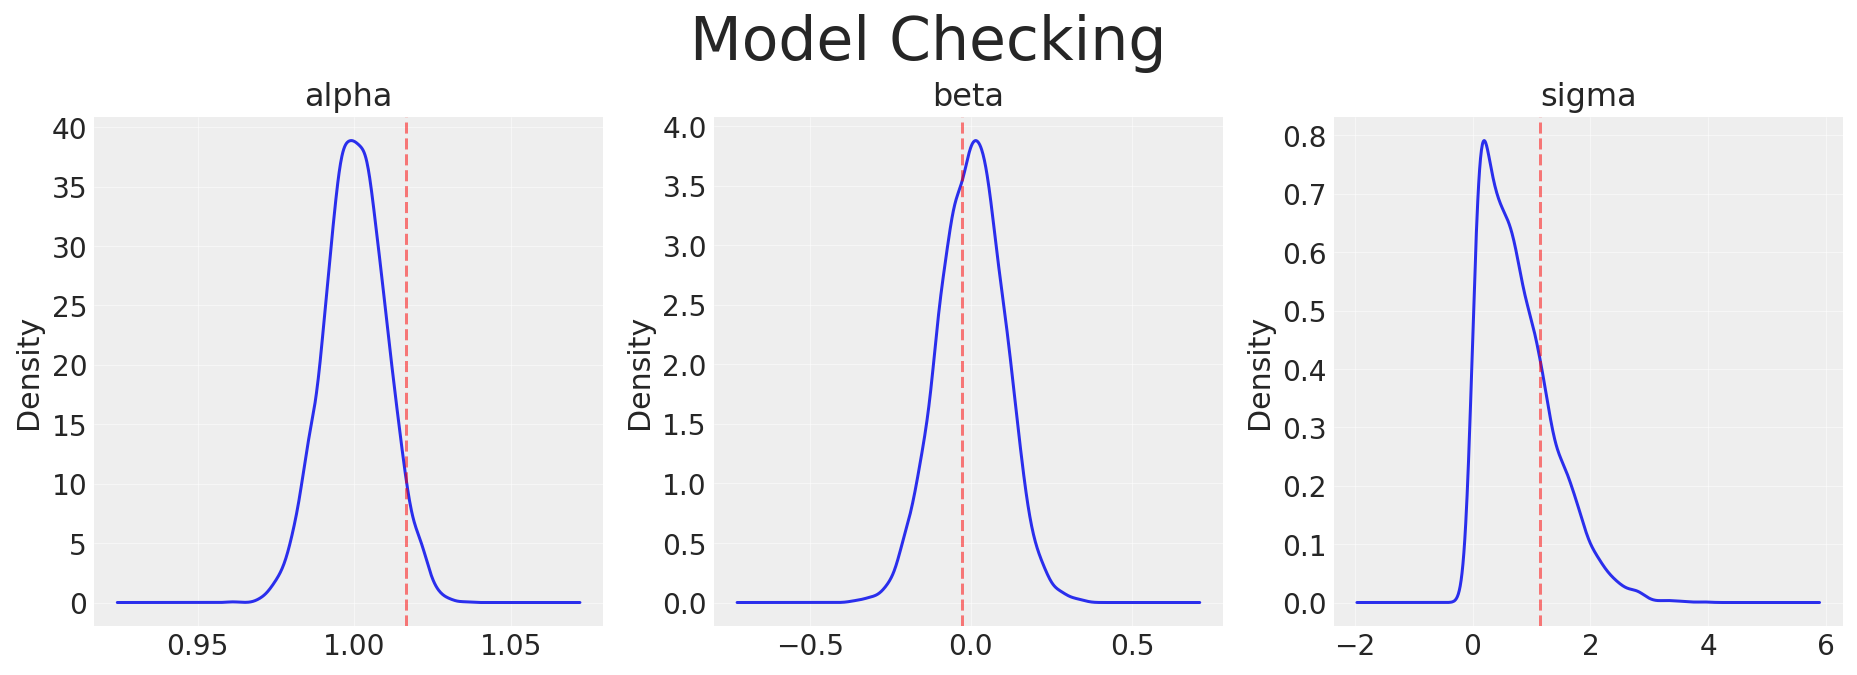

In [153]:
fig, axes = plt.subplots(nrows=max(2, math.ceil(fake_fit.shape[1] / 6)), ncols=3, sharex=False, sharey = False, figsize=(13,8))
fig.suptitle('Model Checking', y = 1.04, size = 30)
axes_list = [item for sublist in axes for item in sublist] 
parameters = parameter_df.groupby("variable")['variable'].last().sort_values(ascending=True).index
grouped = parameter_df.groupby("variable")

for parameter in parameters:
    selection = grouped.get_group(parameter)
    ax = axes_list.pop(0)
    selection.plot.kde(label=parameter, ax=ax, legend=False)
    ax.set_title(parameter)
    ax.grid(linewidth=0.25)
    ax.axvline(x=true_parameters[parameter], color='red', linestyle='--', alpha = 0.5)

# Now use the matplotlib .remove() method to delete anything we didn't use
for ax in axes_list:
    ax.remove()

plt.tight_layout();

In [ ]:
def model_checking(df, feature, m_score, title):
    # We can ask for ALL THE AXES and put them into axes
    fig, axes = plt.subplots(nrows=6, ncols=6, sharex=False, sharey = False, figsize=(25,15))
    fig.suptitle('{}'.format(title), y = 1.04, size = 30)
    axes_list = [item for sublist in axes for item in sublist] 
    axes_list1 = [item for sublist in axes for item in sublist] 
    ordered_country_names = df.groupby("country")['country'].last().sort_values(ascending=True).index
    grouped = df.groupby("country")
    
    for countryname in ordered_country_names:
        selection = grouped.get_group(countryname)
        ax = axes_list.pop(0)
        selection.plot(x='batch_date', y='{}'.format(feature), label=countryname, ax=ax, legend=False)
        
        if m_score is True:
            mscore = list(grouped.get_group(countryname).query('m_score > 5')['batch_date'])
            for xc in mscore:
                ax.axvline(x=xc, color='red', linestyle='--', alpha = 0.3)
        
        ax.set_title(countryname)
        ax.grid(linewidth=0.25)
        ax.set_xticks([])
        ax.set_xlabel('')
    
    # Ensure only labels exist on the last row for each  column
    for ax in [item for item in axes_list1 if item not in axes_list][-6:]:
        ax.set_xticks(pd.date_range(df[['batch_date']].min()['batch_date'], df[['batch_date']].max()['batch_date'], freq='2W').strftime("%Y-%m-%d").tolist())
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
        ax.xaxis.set_minor_formatter(mdates.DateFormatter("%Y-%m-%d"))
        ax.tick_params(labelrotation=45)
    
    # Now use the matplotlib .remove() method to 
    # delete anything we didn't use
    for ax in axes_list:
        ax.remove()
    
    plt.tight_layout();

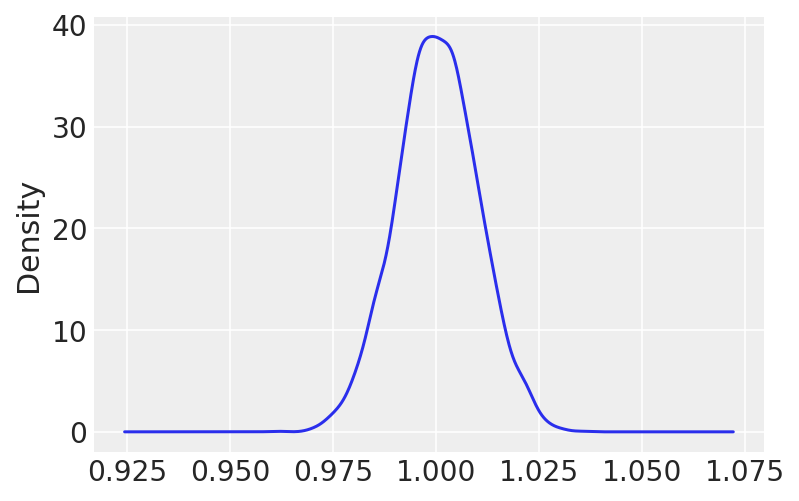

## Fit model on real data

In [5]:
pm_data = dict(N = len(train),
              log_sales_price = train['log_sales_price_std'],
              log_lot_area = train['log_lot_area_z'],
              N_test = len(test),
              log_lot_area_test = test['log_lot_area_z'],
              alpha_sd = 0.01, 
              beta_sd = 0.1, 
              run_estimation = 1)

fit_pm = pooling_model.sampling(data=pm_data)

pm_az = az.from_pystan(
    posterior=fit_pm,
    posterior_predictive="y_hat",
    observed_data="log_sales_price",
    log_likelihood='log_lik',
)

fit_pm_df = fit_pm.to_dataframe()

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


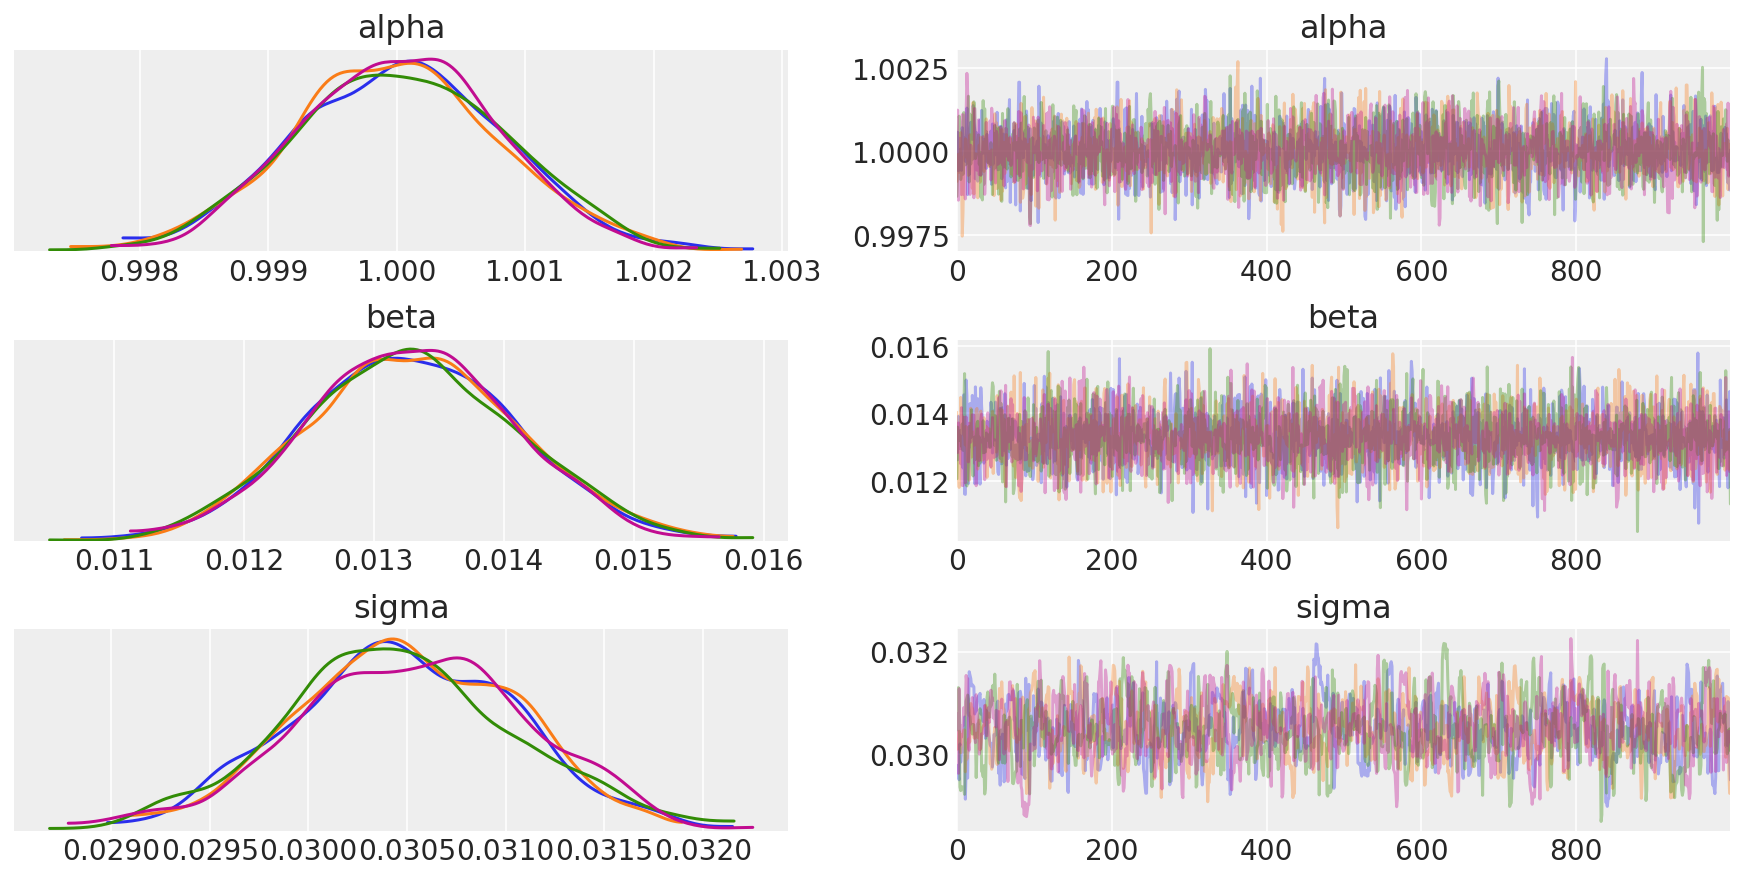

In [10]:
az.plot_trace(fit_pm, var_names=["alpha", "beta", "sigma"], compact = True);

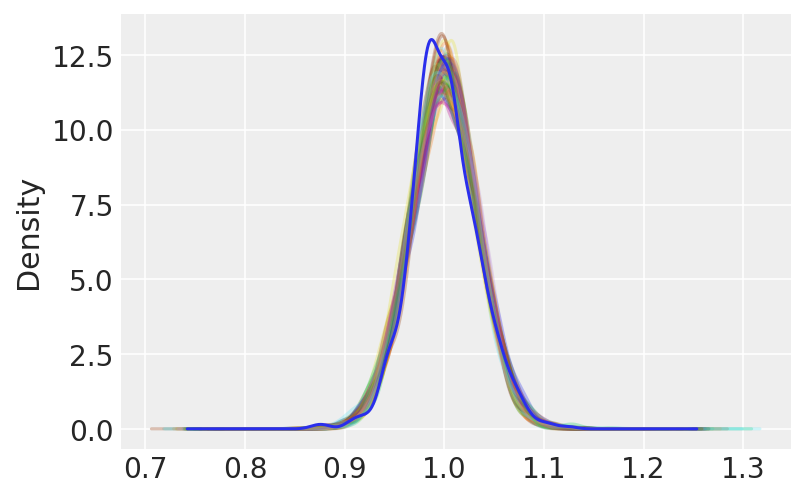

In [11]:
fig, axes = plt.subplots(1,1)

fit_pm_df.filter(regex = 'y_hat').T.iloc[:, :100].plot.kde(alpha=0.3,
                                                        legend = False,
                                                               ax=axes);

train['log_sales_price_std'].plot.kde(legend = False, 
                             alpha = 1,
                             ax = axes);

array([<matplotlib.axes._subplots.AxesSubplot object at 0x140737940>],
      dtype=object)

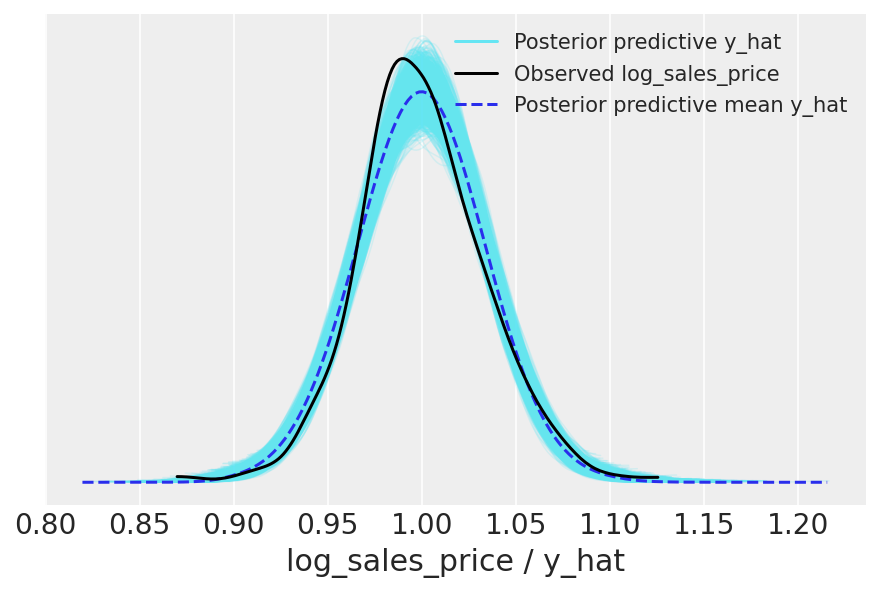

In [12]:
az.plot_ppc(data = pm_az, kind = 'density', data_pairs = {'log_sales_price' : 'y_hat'})

In [15]:
predictions = pd.DataFrame(np.exp(fit_pm_df.filter(regex = 'y_test').mean(axis=0)*train['log_sales_price'].mean()),
                  columns = ['SalePrice'])\
                  .reset_index()\
                  .drop('index', axis = 1)

pooling_csv = pd.concat([test[['Id']].reset_index().drop('index', axis = 1), 
                                   predictions], axis=1)

pooling_csv.to_csv('../data/submissions/pooled_model.csv', index = False)

In [16]:
%%sh
cd ../data/submissions/;
kaggle competitions submit -c house-prices-advanced-regression-techniques -f pooled_model.csv -m "Pooled OLS model"

Successfully submitted to House Prices: Advanced Regression Techniques

100%|██████████| 33.7k/33.7k [00:07<00:00, 4.50kB/s]
